### 心電図でわかること
- 心拍数がわかる
- 不整脈がある程度わかる, etc..

### やりたいこと
心電図を計測して、今までIGOR pro で解析したことを Python でも実行できるようにしたい<br>
（python ライブラリが使える部分はたくさん使っていく方針）

お勉強
- http://hclab.sakura.ne.jp/stress_nervous_rri_interp.html

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

### measurement conditions
- amplifier
    - gain : 60db
    - low pass filter : 300 Hz
    - high pass filter : 0.5 Hz
- A/D converter
    - sampling freq : 1000 Hz
    - resolution : 16 bit
    - input colutage range ±5V
- subject info
    - age : 24
    - sex : M
    - number : 1
    - status : resting
- measurement time
    - 5 min
- lead
    - NASA

In [2]:
#num data
5*60*1000

300000

In [3]:
df_ecg = pd.read_csv('./data/ECG_data_rest.csv', sep=',')
print(df_ecg.shape)
df_ecg.head()

(300000, 2)


,raw data,heart rate
0,0.142324,82.7744
1,0.132390,84.5805
2,0.120332,76.2853
3,0.116204,76.0140
4,0.115019,76.3524


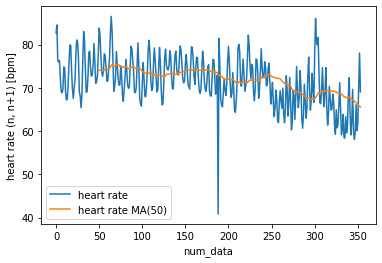

In [4]:
plt.plot(df_ecg['heart rate'], label='heart rate')
plt.plot(df_ecg['heart rate'].rolling(50).mean().round(1), label='heart rate MA(50)')
plt.xlabel('num_data')
plt.ylabel('heart rate (n, n+1) [bpm]')
plt.legend()

なんか下がってる。計測中に心拍数落ち着いてきたのかな

(0.0, 2000.0)

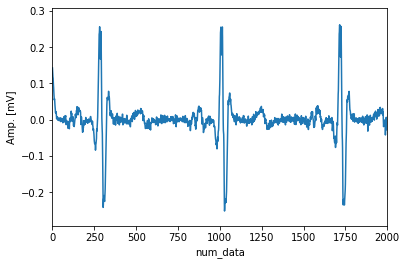

In [5]:
plt.plot(df_ecg['raw data'])
plt.ylabel('Amp. [mV]')
plt.xlabel('num_data')
plt.xlim(0,2000)

### try using BioSppy
ref.<br>1. https://biosppy.readthedocs.io/en/stable/ <br>2. https://github.com/PIA-Group/BioSPPy<br>
quotation : https://zenn.dev/kn1cht/articles/apple-watch-ecg-python

Pythonで生体情報を扱えるライブラリは複数ある。<br>
今回はBioSPPyを使用する。<br>
信号処理やパターン認識などの技術が搭載されており、光電容積脈波（PPG）・心電（ECG）・皮膚電気活動（EDA）・脳波（EEG）・筋電（EMG）・呼吸をサポートしているらしい。<br>

In [15]:
from biosppy.signals import ecg

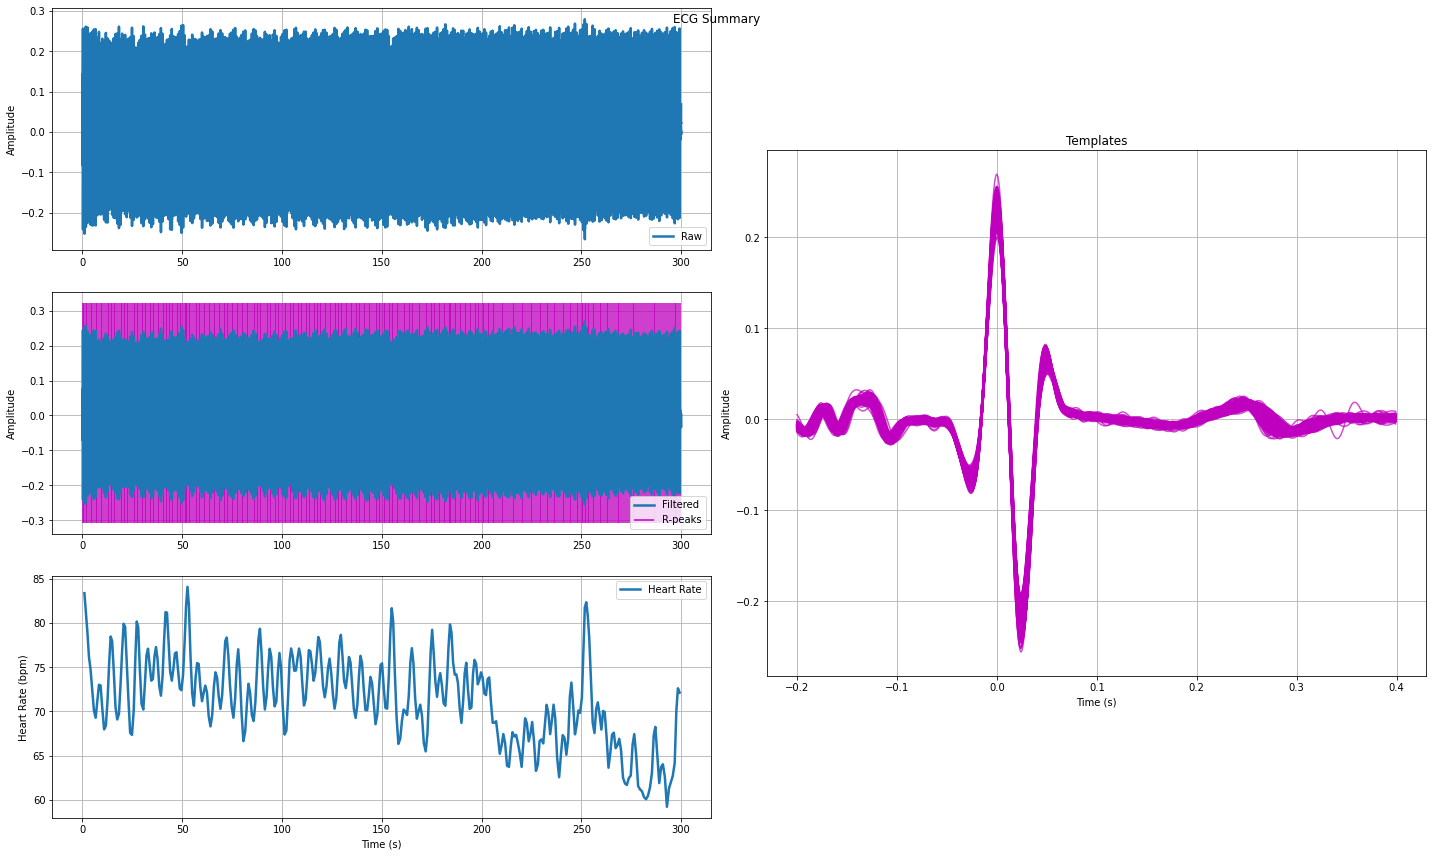

In [7]:
plt.rcParams['figure.figsize'] = [20, 12]

ecg_data = ecg.ecg(signal=df_ecg['raw data'], sampling_rate=1000., show=True)

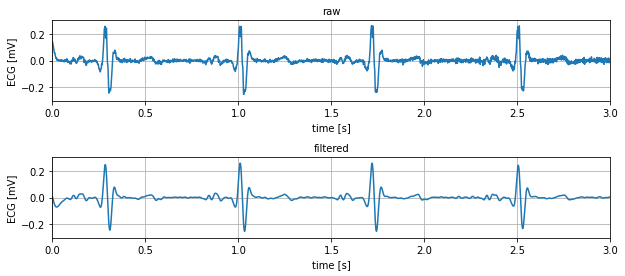

In [8]:
(ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate) = ecg_data

fig = plt.figure(figsize=(10, 4))
plt.subplots_adjust(wspace=0.4, hspace=0.7)

for (i, data, title) in [(1, df_ecg['raw data'], 'raw'), (2, filtered, 'filtered')]:
    ax = fig.add_subplot(2, 1, i)
    ax.plot(ts, data)
    ax.set_title(title, fontsize=10)
    ax.set_xlim(0, 3)
    ax.set_ylim(-0.3, 0.3)
    ax.set_xlabel('time [s]')
    ax.set_ylabel('ECG [mV]')
    ax.grid()

plt.show()

3~45Hzのバンドパスフィルタをかけているみたい
### R wave detection

BioSPPyのECGモジュールには、5種類のR波検出アルゴリズムが実装<br>
それぞれの論文は、一部を除いて公式ドキュメントに引用されている<br>
ref. https://biosppy.readthedocs.io/en/stable/biosppy.signals.html#biosppy-signals-ecg<br>

標準のecg.ecg()で呼び出されているのはhamilton_segmenter()<br>

- christov_segmenter() : (Christov, 2004)
- engzee_segmenter() : (Engelse and Zeelenberg, 1979; Lourenco et al., 2012)
- gamboa_segmenter() : (Gamboa, 2008)
- hamilton_segmenter() : (Hamilton, 2002)
- ssf_segmenter() : (Zong et al., 2003)

In [9]:
sampling_frequency = 1000.
(ts, filtered, _, _, _, _, _,) = ecg.ecg(signal=df_ecg['raw data'], sampling_rate=1000., show=False)

rpeaks_christov, = ecg.christov_segmenter(filtered, sampling_frequency)
rpeaks_engzee, = ecg.engzee_segmenter(filtered, sampling_frequency)
rpeaks_gamboa, = ecg.gamboa_segmenter(filtered, sampling_frequency)
rpeaks_hamilton, = ecg.hamilton_segmenter(filtered, sampling_frequency)
# rpeaks_ssf, = ecg.ssf_segmenter(filtered, sampling_frequency)
# rpeaks_ssf_2000, = ecg.ssf_segmenter(filtered, sampling_frequency, threshold=20.)

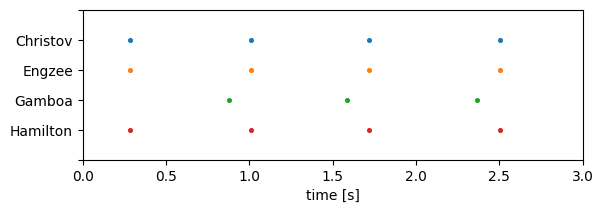

In [10]:
fig = plt.figure(figsize=(5, 1.5), dpi=100)
ax = fig.add_axes([0, 0, 1, 1])

scatter_rpeaks = lambda y, peaks: ax.scatter(ts[peaks], np.tile(y, len(peaks)), s=7)
scatter_rpeaks(1, rpeaks_christov)
scatter_rpeaks(2, rpeaks_engzee)
scatter_rpeaks(3, rpeaks_gamboa)
scatter_rpeaks(4, rpeaks_hamilton)
# scatter_rpeaks(5, rpeaks_ssf)
# scatter_rpeaks(6, rpeaks_ssf_2000)

ax.set_xlabel('time [s]')
ax.set_xlim(0,3)
ax.set_yticks(np.arange(6))
ax.set_yticklabels(['', 'Christov', 'Engzee', 'Gamboa', 'Hamilton'])#, 'SSF(threshold=20)', 'SSF(threshold=2000)'])
ax.invert_yaxis()

### RRI

In [11]:
ts_peaks = ts[rpeaks_christov]
rri = np.diff(ts_peaks) * 1000

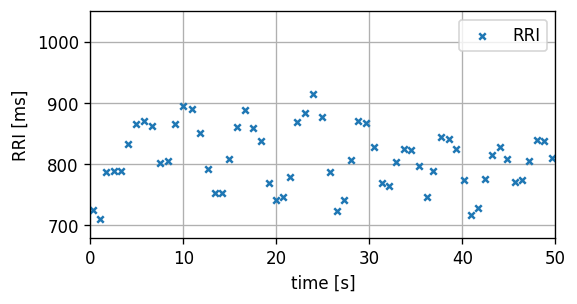

In [12]:
fig = plt.figure(figsize=(5, 2.5), dpi=120)
plt.scatter(ts_peaks[:-1], rri, marker='x', s=15, label='RRI', zorder=2)
plt.xlabel('time [s]')
plt.ylabel('RRI [ms]')
plt.xlim(0, 50)
plt.grid()
plt.legend()

In [13]:
spline_func = scipy.interpolate.interp1d(ts_peaks[:-1], rri, kind='cubic')
ts_1sec = np.arange(ts_peaks[0], ts_peaks[-2], 1)
rri_1sec = spline_func(ts_1sec).round(6)

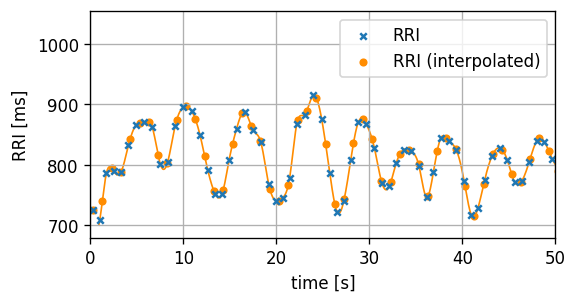

In [14]:
fig = plt.figure(figsize=(5, 2.5), dpi=120)

plt.scatter(ts_peaks[:-1], rri, marker='x', s=15, label='RRI', zorder=2)
plt.scatter(ts_1sec, rri_1sec, s=15, color='darkorange', label='RRI (interpolated)')
x = np.arange(0.9, 50, 0.05)
plt.plot(x, spline_func(x), color='darkorange', lw=1, zorder=-1)

plt.xlabel('time [s]')
plt.ylabel('RRI [ms]')
plt.xlim(0, 50)
plt.grid()
plt.legend()

補間手法による影響はあまりない、というのが一般的な認識
- そもそもストレス指標自体は、ぶれ（分散）の指標なので、補間手法の差異によるずれは相対的に小さな誤差となるのであまり問題ないもよう

### RRV (R-R interval Variability)

- HR
    - 5分間の全心拍数の平均値
- Mean（ms）
    - 5分間のRR間隔の平均
- SDNN（ms）
    - 5分間のRR間隔の標準偏差
- RMSSD（ms）
    - 連続して隣接するRR間隔の差の２乗の平均値の平方根であり、迷走神経緊張強度の指標
- NN50
    - 連続した隣接するRR間隔の差が50msを超える総数で、迷走神経緊張強度の指標
- pNN50（%）
    - 連続した隣接するRR間隔の差が50msを超える心拍の割合で、迷走神経緊張強度の指標
- SD1
    - プロット散布図の縦軸方向の標準偏差
- SD2
    - プロット散布図の横軸方向の標準偏差
    
### ref.
1. https://www.trytech.co.jp/checkmyheart/glossary.html
2. https://www.ahajournals.org/doi/10.1161/01.CIR.93.5.1043
3. hrv-analysis 1.0.4
    - https://pypi.org/project/hrv-analysis/
    - https://github.com/Aura-healthcare
    - https://aura-healthcare.github.io/hrv-analysis/index.html

### Try using hrv-analysis1.0.4 (Feature calcuation)
### Time domain features

In [16]:
from hrvanalysis import get_time_domain_features
from hrvanalysis import plot_psd
from hrvanalysis import plot_poincare
from hrvanalysis import get_frequency_domain_features
from hrvanalysis import get_csi_cvi_features


In [32]:
#nn_intervals_list contains integer values of NN-interval
nn_intervals_list = list(rri_1sec)

time_domain_features = get_time_domain_features(nn_intervals_list)

In [33]:
time_domain_features

{'mean_nni': 847.1879737491638,
 'sdnn': 68.00496905255504,
 'sdsd': 54.883250245152745,
 'nni_50': 131,
 'pnni_50': 43.95973154362416,
 'nni_20': 229,
 'pnni_20': 76.84563758389261,
 'rmssd': 54.884393830079034,
 'median_nni': 842.876223,
 'range_nni': 336.32304299999987,
 'cvsd': 0.06478419846683194,
 'cvnni': 0.08027140511875351,
 'mean_hr': 71.26838140629862,
 'max_hr': 85.55738508140581,
 'min_hr': 57.825375669202955,
 'std_hr': 5.593473562754947}

### Frequency domain features

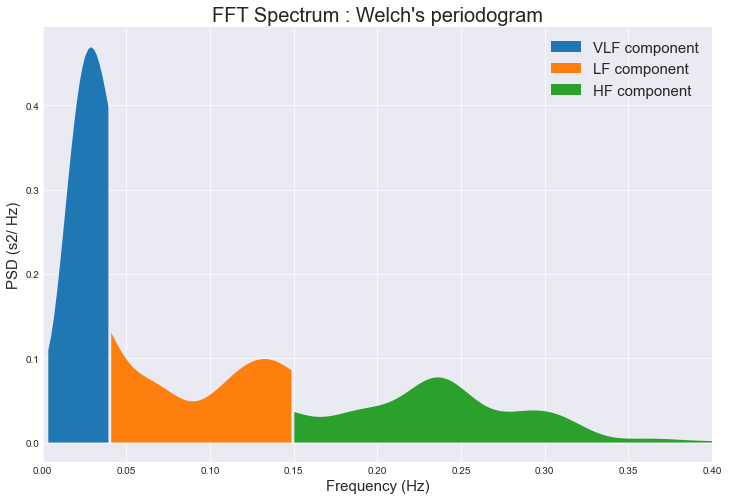

In [50]:
plot_psd(nn_intervals_list, method="welch")

ref. https://www.trytech.co.jp/checkmyheart/glossary.html#word2_02
- VLF（超低周波 ms²）
    - 0.0033〜0.04Hzの周波数帯のパワースペクトルです。この周波数帯におけるパワースペクトルのVLF成分と生理学的メカニズムの関連については、よく分っていません。一般的に、このパラメータは交感神経機能の非常にゆっくりとしたメカニズムの全体的活動を示すものとして知られています。
- LF（低周波 ms²）
    - 0.004〜0.15Hzの周波数帯のパワースペクトルです。この値は（血管運動性）交感神経と副交感神経の両方の活動を反映しています。この周波数帯に対する副交感神経の影響は、呼吸数が1分間に9回（周波数0.15Hz）以下の深呼吸をしている間LFに現れます。したがってリラックスした状態でゆっくりと規則正しい呼吸をしている時、LF値は大変高く、これは交感神経活動の増大ではなく副交感神経の増大を意味しています。
- HF（高周波 ms²）
    - 0.15〜0.4Hzの周波帯のパワースペクトルである。この値は副交感神経（迷走神経）の活動を反映しています。HFはRSA（呼吸性洞性不整脈）として知られており、呼吸によるRR間隔の変動を示すため、「呼吸帯」としても知られています。心拍数は息を吸い込むとき増大し、吐き出す時減少する。 ゆっくりとした規則正しい呼吸は、パワースペクトルのHFピークの振幅を増大させます。
- LF/HF比
    - LF（低周波）とHF（高周波）のパワーの比率です。この値は、交感神経と副交感神経の全体のバランスを表しています。数値が高いと交感神経優位を、低い場合は副交感神経優位を示しています。しかしながら、規則正しい深呼吸をしているときの高いRSA（呼吸）効果による副交感神経活動の増大を反映していることを考慮する必要があります。 LF/HF比率は補正された値で計算されます。

In [48]:
frequency_domain_features = get_frequency_domain_features(nn_intervals_list, method='welch',)


In [49]:
frequency_domain_features

{'lf': 495.1521386384133,
 'hf': 1160.3846343757468,
 'lf_hf_ratio': 0.4267138015876871,
 'lfnu': 29.908857762000203,
 'hfnu': 70.09114223799979,
 'total_power': 2073.060091884284,
 'vlf': 417.5233188701235}

### Non Linear domain features

In [52]:
csi_cvi_features = get_csi_cvi_features(nn_intervals_list)

In [53]:
csi_cvi_features

{'csi': 2.262898653556849,
 'cvi': 4.7380945514718285,
 'Modified_csi': 796.2417247184085}

- CSI : Cardiac Sympathetic Index
    - 交感神経指標
- CVI : Cardic Vagal Index
    - 副交感神経指標
- https://www.santeku-map.com/Catalog_MaP1060.pdf

## Next
どのように上記の値が、どういう状態の時に変化するのか

## Compare Rest and Exercise

### measurement conditions
- amplifier
    - gain : 60db
    - low pass filter : 300 Hz
    - high pass filter : 0.5 Hz
- A/D converter
    - sampling freq : 1000 Hz
    - resolution : 16 bit
    - input colutage range ±5V
- subject info
    - age : 24
    - sex : M
    - number : 1
    - status : exercising (ergometer)
- measurement time
    - 5 min
- lead
    - NASA

the data to compare is LF/HF
- rest
    - 'lf_hf_ratio': 0.4267138015876871,

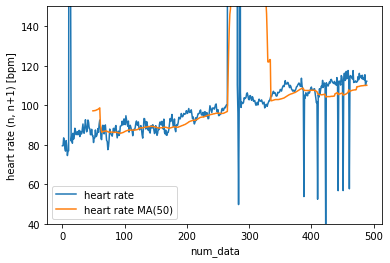

In [8]:
#reading exercise csv data
df_ecg_ex = pd.read_csv('./data/ECG_data_exercise.csv', sep=',')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df_ecg_ex['heart rate'], label='heart rate')
ax.plot(df_ecg_ex['heart rate'].rolling(50).mean().round(1), label='heart rate MA(50)')
ax.set_xlabel('num_data')
ax.set_ylabel('heart rate (n, n+1) [bpm]')
ax.set_ylim(40,150)
plt.legend()

↑計測中に算出したheart rateは外れ値を出してるみたい。<br>
- これは確か、heart rateは閾値を指定してやっていた
    - そこがロバストに検出できてなかったのかな

(0.0, 2000.0)

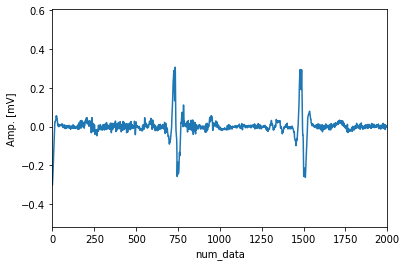

In [11]:
plt.plot(df_ecg_ex['raw data'])
plt.ylabel('Amp. [mV]')
plt.xlabel('num_data')
plt.xlim(0,2000)

In [18]:
sampling_frequency = 1000
(ts, filtered, _, _, _, _, _,) = ecg.ecg(signal=df_ecg_ex['raw data'], sampling_rate=1000., show=False)
rpeaks_christov, = ecg.christov_segmenter(filtered, sampling_frequency)

ts_peaks = ts[rpeaks_christov]
rri = np.diff(ts_peaks) * 1000

spline_func = scipy.interpolate.interp1d(ts_peaks[:-1], rri, kind='cubic')
ts_1sec = np.arange(ts_peaks[0], ts_peaks[-2], 1)
rri_1sec = spline_func(ts_1sec).round(6)

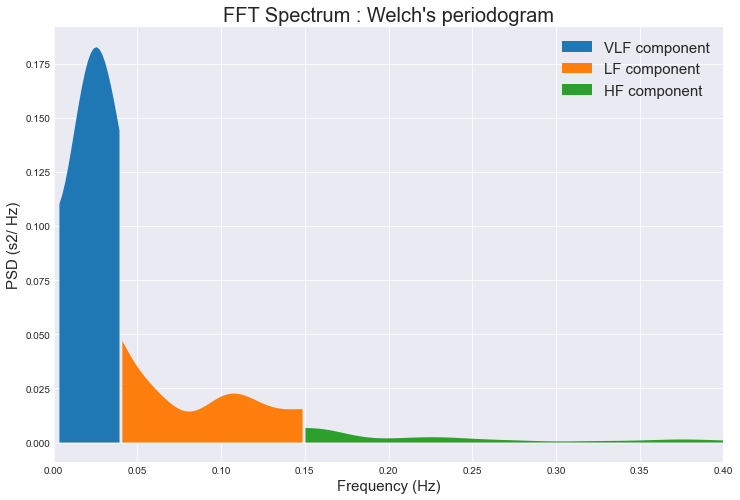

In [19]:
nn_intervals_list = list(rri_1sec)
plot_psd(nn_intervals_list, method="welch")

In [56]:
frequency_domain_features = get_frequency_domain_features(nn_intervals_list, method='welch',)

frequency_domain_features

{'lf': 146.72917735549612,
 'hf': 92.33534454216894,
 'lf_hf_ratio': 1.589090050868721,
 'lfnu': 61.37639169157254,
 'hfnu': 38.62360830842746,
 'total_power': 370.0753248270936,
 'vlf': 131.01080292942854}

the data to compare is LF/HF
- rest
    - 'lf_hf_ratio': 0.4267138015876871,
- exercise
    - 'lf_hf_ratio': 1.589090050868721,

運動負荷を与えることによってLF/HFは上昇し、ストレス傾向にあることがわかった（n=1）

> 副交感神経が優位にある場合にHF成分が現れるため、HF成分の数値を副交感神経の活性度（緊張度）とする場合もあります。また、交感神経が優位でも、副交感神経が優位でも、LF成分が現れるため、LFとHFの比をとって、LF／HFをストレス指標（交感神経の活性度）とします。

> リラックスしている状態、つまり副交感神経が活性化しているときには、呼吸変動を反映したHF成分と血圧変動を反映したLF成分も現れますが、ストレス状態にある場合、つまり交感神経が活性化しているときには、LF成分が現れる一方、HF成分が減少します。従って、リラックス状態にあると相対的にHF成分が大きくなるのでLF/HFの値は小さくなり、反対に、ストレス状態にあるとHFに対してLF成分が大きくなるのでLF/HFの値が大きくなります。このLF/HFが幾つ以上になるとストレス状態と判定するか、という判定基準は、個人差や測定条件等により変わってくるのが実際です。
### 問題点
>しかしながら、この指標、LF、HFはそれほど安定した確度の高い指標ではないのが実際です。指標の算出過程も複数の手法が存在しており、それぞれが算出するLF、HFが同じであることはありません。また、個人差（年齢や疾患含む）や測定条件によっても大きく値がことなってきます。そして最も重要な問題は、自律神経機能は心拍変動に影響を与える要因の一つでしかなく、その他にも様々な臓器、器官の機能が心拍変動に影響を与えており、心拍変動の詳しいメカニズムが完全には解っていないというところです。そのため、この指標のみで自律神経機能やそのバランスを判断するのは注意を要します。より詳しくは”専門的に学びたい方へ：ストレスと自律神経の科学”を参照ください。

> quo. ストレス指標のHF, LFとは？
- http://hclab.sakura.ne.jp/stress_novice_LFHF.html 

## あとできる(?)こと
- 心電図時系列データからの呼吸数推定方法について
    - https://www.jstage.jst.go.jp/article/jse1981/7/3/7_3_287/_pdf/-char/ja
- 心電図解析による自律神経活動評価に関する研究
    - https://core.ac.uk/download/pdf/59118995.pdf